# Genre Prediction Using Machine Learning

* The goal is to predict between Rap and Pop songs
* Only text infomation from the songs is available
  - Title
  - Artist
  - Lyrics
  - Views
  - Year Released
  - The tag (Genre)
  - Other unused data (e.g. language)

#### ML Models
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient-Boosted Trees

# Libraries and Spark Setup

In [ ]:
# This mounts your Google Drive to Colab, allowing you to access files stored in your Google Drive.
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# This installs the OpenJDK 8, which is a prerequisite for running Apache Spark.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# These lines download Spark version 3.3.3 with Hadoop 3, and then extract the contents from the downloaded archive.
!wget https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
!tar -xvf spark-3.3.3-bin-hadoop3.tgz

In [ ]:
# FindSpark is a Python library that makes it easy to locate and use Spark within a Python environment.
!pip install findspark

In [ ]:
# These lines install additional Python libraries: Pandas, numpy, NLTK (Natural Language Toolkit), and Afinn.
!pip install pandas
!pip install numpy
!pip install nltk
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=ac4461f232e2a394f504f24b8e611dd0ba4d4d3d7a5d4582fc91a274f466f487
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [ ]:
# These lines set the environment variables JAVA_HOME and SPARK_HOME. JAVA_HOME points to the location where Java is installed, and SPARK_HOME points to the Spark installation directory.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

# Data Source Filtering Pre-Processing


In [ ]:
import pandas as pd

# Define the file paths
input_source_file = "/content/drive/MyDrive/SENG_550/data/song_lyrics.csv"
output_file = "/content/drive/MyDrive/SENG_550/data/reduced_song_lyrics.csv"

# Define chunk size (number of rows per chunk)
chunk_size = 100000

print("Starting to filter...")

# Create an iterator to read the CSV in chunks
chunk_iterator = pd.read_csv(input_source_file, chunksize=chunk_size)

# Process each chunk
filtered_chunks = []
for chunk in chunk_iterator:
    # Filter rows where language is "en"
    filtered_chunk = chunk[(chunk["language"] == "en") & (chunk["tag"].isin(["pop", "rap"]))]
    filtered_chunks.append(filtered_chunk)

# Concatenate filtered chunks and write to a new CSV file
filtered_df = pd.concat(filtered_chunks)
filtered_df.to_csv(output_file, index=False)

print("Filtering complete. The new CSV is saved at:", output_file)

Starting to filter...
Filtering complete. The new CSV is saved at: /content/drive/MyDrive/SENG_550/data/reduced_song_lyrics.csv


In [ ]:
import pandas as pd

# Define the file paths
input_source_file = "/content/drive/MyDrive/SENG_550/data/reduced_song_lyrics.csv"
output_file = "/content/drive/MyDrive/SENG_550/data/reduced_pop_and_rap_lyrics.csv"

# Load the CSV file
df = pd.read_csv(input_source_file)

print("Starting to filter...")

# Separate the two categories
pop_df = df[df["tag"] == "pop"]
rap_df = df[df["tag"] == "rap"]

# Downsample the "pop" category to match the size of "rap"
pop_df_downsampled = pop_df.sample(n=len(rap_df), random_state=1)

# Concatenate the downsampled "pop" DataFrame with the "rap" DataFrame
balanced_df = pd.concat([pop_df_downsampled, rap_df])

# Shuffle the dataset if needed
balanced_df = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)

balanced_df.to_csv(output_file, index=False)

print("Filtering complete. The new CSV is saved at:", output_file)

Starting to filter...
Filtering complete. The new CSV is saved at: /content/drive/MyDrive/SENG_550/data/reduced_pop_and_rap_lyrics.csv


# Data Setup
* Spark Context
* Upload CSV data file as dataframe and create a Spark RDD
  - The CSV data contains English Rap and Pop songs
* Create helper functions to view the RDDs later


In [ ]:
# The findspark library helps in locating the Spark installation and adds
# it to the sys.path so that you can import the pyspark modules in your
# Python script or notebook without explicitly specifying the path.
import findspark
findspark.init()

# This code creates a Spark session with the following configurations:
# master("local"): This sets the master URL to "local," indicating that Spark should run in local mode on the machine where the script is executed.
# appName("Colab"): This sets the application name to "Colab."
# .config('spark.ui.port', '4050'): This configures the Spark UI port to 4050. This is optional and can be useful if you want to access the Spark UI in Colab.
# Set up a spark session and a spark context
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Create a spark context
sc = spark.sparkContext

In [ ]:
# General Imports
import pandas as pd
import numpy as np
import re
import string
import math

# specific imports are in the cells they are used in

In [ ]:
# note this requires a a folder in MyDrive called SENG_550
# in this folder is a folder called data which contains the two files
# AFINN-111.txt and the data file.csv
import os.path

afinn_file_name = "AFINN-111.txt"
data_file_name = "musicData_10000rows.csv"

# set up the path to the files
baseDir = os.path.join('.')
inputPathAfinn = os.path.join(f"/content/drive/MyDrive/SENG_550/data/{afinn_file_name}")
inputPathMusicData = os.path.join(f"/content/drive/MyDrive/SENG_550/data/{data_file_name}")

# get the specific path
afinnFile = os.path.join(baseDir, inputPathAfinn)
dataFile = os.path.join(baseDir, inputPathMusicData)

# Read the data into RDDS for the afinn library. ------- this might not be used
afinnRDD = sc.textFile(afinnFile, 1)

# read the music data into a DRR using a numebr of partitions
partitions = 8

# get dataframe data first
df = pd.read_csv(dataFile)

# get the number of data rows
num_of_data_rows = df.shape[0]

# set up the RDD
RDD = spark.sparkContext.parallelize(df.to_dict('records'), partitions)

print("Spark Context Created")


Spark Context Created


In [ ]:
# Test to make sure data has been loaded and can be accessed
numPoints = afinnRDD.count()
print ("Number of data points in the afinn RDD: ",numPoints)
samplePoints = afinnRDD.take(2)
print("Sample of Data")
print (samplePoints)

print("\n--------------------------------------------------------------------------------------------\n")
# the music Data RDD
numPointsMusic = RDD.count()
print ("Number of data points in the RD: ", numPointsMusic)
samplePointsMusic = RDD.take(2)
print("Sample of Data")
print (samplePointsMusic)

Number of data points in the afinn RDD:  2477
Sample of Data
['abandon\t-2', 'abandoned\t-2']

--------------------------------------------------------------------------------------------

Number of data points in the RD:  10000
Sample of Data
[{'title': 'King Speech', 'tag': 'rap', 'artist': 'Neshry', 'year': 2019, 'views': 31, 'features': '{}', 'lyrics': "Yeah\n\nNeshry\n\nUh\n\n{Verse 1}\n\nListen\n\nOnly thing bigger than me is my ego\nWord to the Leos\nWe all relate, i guess am, late to the game\nIts better later than never, am still, early as ever\n\n{Verse 2}\n\nYea, had to stick to the plan\nThe Lion's Den is on fire, i admire\nNiggas who got,bigger game\nAm still waiting for y'all to say my name\nAm prolly at the lowest key\nTo the fact they don't notice me\nAm like, 5 feet, i still stand tall\nAm jumping higher than fives nigga i see it all\nTiptoeing with my crocs to the studio\nBody checking with my bars, don't fool me though\nTo whom it may concern,i've  been on the come u

In [ ]:
# Helper functions to help print the RDD for testing and displaying data
# Only outputs a small amount of data

# Function to split the RDD elements into table elements for viewing - also option to only show lyrics
# Options to show a specific number of elements/rows, show more lyric length, or show only the lyrics
def print_rdd_table(rdd, rows_to_show=10, lyrics_length=10, lyricsOnly=False):
  # Convert RDD elements to a Pandas DataFrame
  df = pd.DataFrame(rdd.take(rows_to_show))

  print(f"First {rows_to_show} rows of RDD. lyric len=" + str(lyrics_length) )

  # Truncate the 'lyrics' column to the specified length
  df['lyrics'] = df['lyrics'].apply(lambda x: x[:lyrics_length] + '...' if len(x) > lyrics_length else x)

  # only show the lyrics column
  if lyricsOnly:
    print(df["lyrics"].to_markdown(index=False))
  else:
    # Print the DataFrame as a table
    print(df.to_markdown(index=False))



# Print the elements of the RDD line my line for only 5 lines
def print_rdd_elements(rdd):
  # Collect the elements of the RDD to the driver program
  rdd_elements = rdd.take(5)

  # Print each element in a readable way
  for element in rdd_elements:
    print(element)

# created a list of num elements of the rdd
def create_list_from_rdd(rdd, num):
  # Collect the elements of the RDD to the driver program
  rdd_elements = rdd.take(num)

  dataPointsList = [] # set up list

  # Print each element in a readable way
  for element in rdd_elements:
    dataPointsList.append(element)

  return dataPointsList

In [ ]:
print("Data in the initial RDD\n")
print_rdd_table(RDD, 5, 4)

Data in the initial RDD

First 5 rows of RDD. lyric len=4
| title                   | tag   | artist           |   year |   views | features   | lyrics   |      id | language_cld3   | language_ft   | language   |
|:------------------------|:------|:-----------------|-------:|--------:|:-----------|:---------|--------:|:----------------|:--------------|:-----------|
| King Speech             | rap   | Neshry           |   2019 |      31 | {}         | Yeah...  | 4516708 | en              | en            | en         |
| Dont Lie No No No       | pop   | Fergie           |   2020 |     722 | {}         | [Int...  | 5742232 | en              | en            | en         |
| Icabod                  | pop   | TR/ST            |   2014 |    3616 | {}         | Whoa...  | 1947969 | en              | en            | en         |
| Travel Baggage Carry On | rap   | AllOne (USA)     |   2016 |      25 | {}         | Fill...  | 3590374 | en              | en            | en         |
| Lost Visio

# Data Cleaning / Processing
Use the Dataframe/Dictionary Structure while setting up data
* Add a label column
* Remove data with no tite/artist/lyrics
* Clean the puncuation of the title/artist/lyrics
  - Remove {verse } [chorus] etc
  - Replace - with a space
  - Remove new lines(\n)
* Create Afinn score for title/artist/lyrics
  - Total score for each
  - Avg score per word for each

In [ ]:
# create a label using the tag/genre category --- rap is 0 and pop is 1
labelledRDD = RDD.map(lambda row: {**row, 'label': 0 if row['tag'] == 'rap' else 1})
print("RDD after creating a label column\n")
print_rdd_table(labelledRDD, 5, 4)

RDD after creating a label column

First 5 rows of RDD. lyric len=4
| title                   | tag   | artist           |   year |   views | features   | lyrics   |      id | language_cld3   | language_ft   | language   |   label |
|:------------------------|:------|:-----------------|-------:|--------:|:-----------|:---------|--------:|:----------------|:--------------|:-----------|--------:|
| King Speech             | rap   | Neshry           |   2019 |      31 | {}         | Yeah...  | 4516708 | en              | en            | en         |       0 |
| Dont Lie No No No       | pop   | Fergie           |   2020 |     722 | {}         | [Int...  | 5742232 | en              | en            | en         |       1 |
| Icabod                  | pop   | TR/ST            |   2014 |    3616 | {}         | Whoa...  | 1947969 | en              | en            | en         |       1 |
| Travel Baggage Carry On | rap   | AllOne (USA)     |   2016 |      25 | {}         | Fill...  | 3590374 |

In [ ]:
# Remove the record that doesn't have a title/artist/lyrics
filteredRDD = labelledRDD.filter(lambda row: 'artist' in row and 'title' in row and 'lyrics' in row and "year" in row and "views" in row)

# show the results
print("Filtered None values out of data\n")
print_rdd_table(filteredRDD, 10, 4)
print("\n New count of data points")
filteredRDD.count()

Filtered None values out of data

First 10 rows of RDD. lyric len=4
| title                      | tag   | artist                |   year |   views | features             | lyrics   |      id | language_cld3   | language_ft   | language   |   label |
|:---------------------------|:------|:----------------------|-------:|--------:|:---------------------|:---------|--------:|:----------------|:--------------|:-----------|--------:|
| King Speech                | rap   | Neshry                |   2019 |      31 | {}                   | Yeah...  | 4516708 | en              | en            | en         |       0 |
| Dont Lie No No No          | pop   | Fergie                |   2020 |     722 | {}                   | [Int...  | 5742232 | en              | en            | en         |       1 |
| Icabod                     | pop   | TR/ST                 |   2014 |    3616 | {}                   | Whoa...  | 1947969 | en              | en            | en         |       1 |
| Travel Baggage 

10000

In [ ]:
# clean the lyrics, artist and title
def clean_text(text):
    # Remove text between curly braces {}
    text = re.sub(r'\{.*?\}', '', text)

    # Remove text between square brackets []
    text = re.sub(r'\[.*?\]', '', text)

    text = text.replace('-', ' ')

    # Use translation table to remove punctuation
    translator = str.maketrans("", "", string.punctuation)

    # Remove newline characters
    text = text.replace('\n\n', ' ')
    text = text.replace('\n', ' ')

    # Remove punctuation
    text = text.translate(translator)

    return text


# Apply the clean_lyrics function to the 'lyrics' column
cleanedRDD = filteredRDD.map(lambda row: {
    **row,
    'lyrics': clean_text(row['lyrics']),
    'artist': clean_text(row['artist']),
    'title': clean_text(row['title'])
})

# show the results
print("Lyrics after cleaning data")
print_rdd_table(cleanedRDD, 1, 100, True)

Lyrics after cleaning data
First 1 rows of RDD. lyric len=100
| lyrics                                                                                                  |
|:--------------------------------------------------------------------------------------------------------|
| Yeah Neshry Uh  Listen Only thing bigger than me is my ego Word to the Leos We all relate i guess am... |


In [ ]:
# Set up the AFINN Scores or numeric data before the ML uses it for predictions

from afinn import Afinn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# use the afinnRDD to get a dictionary
afinn_dict = dict([(w_s[0], int(w_s[1])) for w_s in [ws.strip().split('\t') for ws in afinnRDD.collect()]])
# where i have ---- i realized I need to access what is in the rdd line by line

# function to generate an avg sentiment score from a text sting
def get_avg_afinn_score(text):
    words = re.compile(r"\W+").split(text.lower())
    sentiments = list(map(lambda word: afinn_dict.get(word, 0), words))
    if sentiments:
        sentiment = float(sum(sentiments))/math.sqrt(len(sentiments))
    else:
        sentiment = 0
    return sentiment


# Create an Afinn object for sentiment analysis totals (uses the installed library)
afinn = Afinn()

# Fit and transform the artist column
numericRDD = cleanedRDD.map(lambda row: {
    **row,
    'title_sentiment': afinn.score(row['title']),
    'lyrics_sentiment': afinn.score(row['lyrics']),
    'artist_sentiment': afinn.score(row['artist']),

    'title_sentiment_avg': get_avg_afinn_score(row['title']),
    'lyrics_sentiment_avg': get_avg_afinn_score(row['lyrics']),
    'artist_sentiment_avg': get_avg_afinn_score(row['artist'])
})


# show the results of this section - final Dataframe/Dictionary like RDD before ML alters it
print("Final Data conersions before ML\n")
print_rdd_table(numericRDD, 5, 4)

Final Data conersions before ML

First 5 rows of RDD. lyric len=4
| title                   | tag   | artist           |   year |   views | features   | lyrics   |      id | language_cld3   | language_ft   | language   |   label |   title_sentiment |   lyrics_sentiment |   artist_sentiment |   title_sentiment_avg |   lyrics_sentiment_avg |   artist_sentiment_avg |
|:------------------------|:------|:-----------------|-------:|--------:|:-----------|:---------|--------:|:----------------|:--------------|:-----------|--------:|------------------:|-------------------:|-------------------:|----------------------:|-----------------------:|-----------------------:|
| King Speech             | rap   | Neshry           |   2019 |      31 | {}         | Yeah...  | 4516708 | en              | en            | en         |       0 |                 0 |                -10 |                  0 |               0       |              -0.598684 |               0        |
| Dont Lie No No No       | pop

# Exploratory Data Analysis

The first exploratory data analysis information are some quick facts about the dataset.

In [ ]:
print("Number of songs in the dataset: ", cleanedRDD.count())
print("Number of unique artists in the dataset: ", cleanedRDD.map(lambda row: row["artist"]).distinct().count())

song_year_counts = cleanedRDD.map(lambda row: (row["year"], 1))
song_year_counts_reduced = song_year_counts.reduceByKey(lambda a, b: a + b)
most_common_year = song_year_counts_reduced.max(key = lambda x: x[1])
print(f"The most common year of song release is: {most_common_year[0]} with {most_common_year[1]} occurrences.")

Number of songs in the dataset:  10000
Number of unique artists in the dataset:  8925
The most common year of song release is: 2020 with 1179 occurrences.


The next cell displays the top 5 artists from each genre.

In [ ]:
genre_artist_pairs = cleanedRDD.map(lambda row: ((row["tag"], row["artist"]), 1))
genre_artist_counts = genre_artist_pairs.reduceByKey(lambda a, b: a + b)

# Rearrange from ((genre, artist), count) to (genre, (artist, count))
rearranged_genre_artist = genre_artist_counts.map(lambda x: (x[0][0], (x[0][1], x[1])))
grouped_by_genre = rearranged_genre_artist.groupByKey()

top_5_artists_by_genre = grouped_by_genre.map(lambda x: (x[0], sorted(list(x[1]), key = lambda y: y[1], reverse = True)[:5]))

top_artists = top_5_artists_by_genre.collect()

for genre, artists in top_artists:
    print(f"Top 5 artists for genre {genre}:")
    for artist, count in artists:
        print(f"  {artist} with {count} songs")
    print()

Top 5 artists for genre rap:
  Genius English Translations with 14 songs
  KAAN with 7 songs
  Gucci Mane with 7 songs
  Juice WRLD with 7 songs
  BONES with 6 songs

Top 5 artists for genre pop:
  Genius English Translations with 36 songs
  Frank Sinatra with 6 songs
  Ella Fitzgerald with 5 songs
  KIDZ BOP Kids with 4 songs
  Mates of State with 4 songs



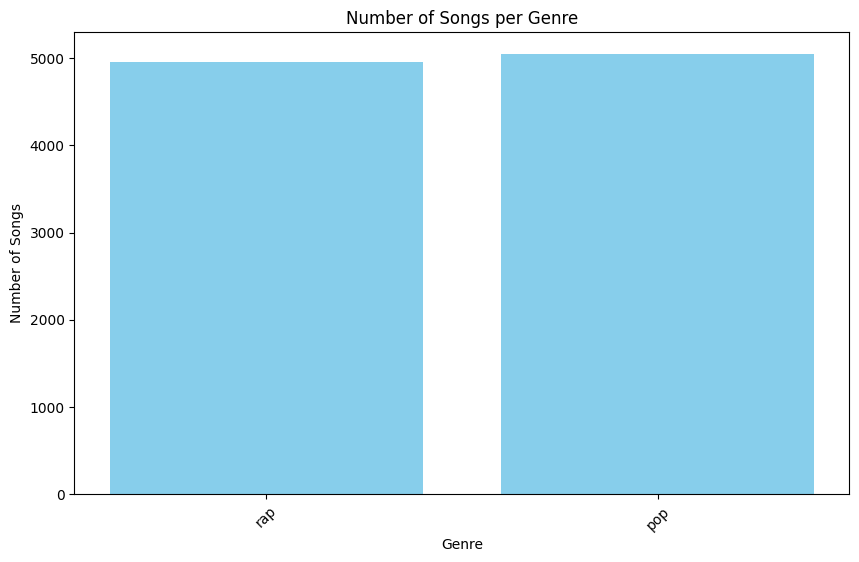

In [ ]:
import matplotlib.pyplot as plt
from operator import add

genre_counts = cleanedRDD.map(lambda row: (row["tag"], 1)).reduceByKey(add)
genre_counts_local = genre_counts.collect()

# Unzipping the genre names and their counts
genres, counts = zip(*genre_counts_local)

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color="skyblue")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.title("Number of Songs per Genre")
plt.xticks(rotation=45)  # Rotates the genre labels for better readability
plt.show()

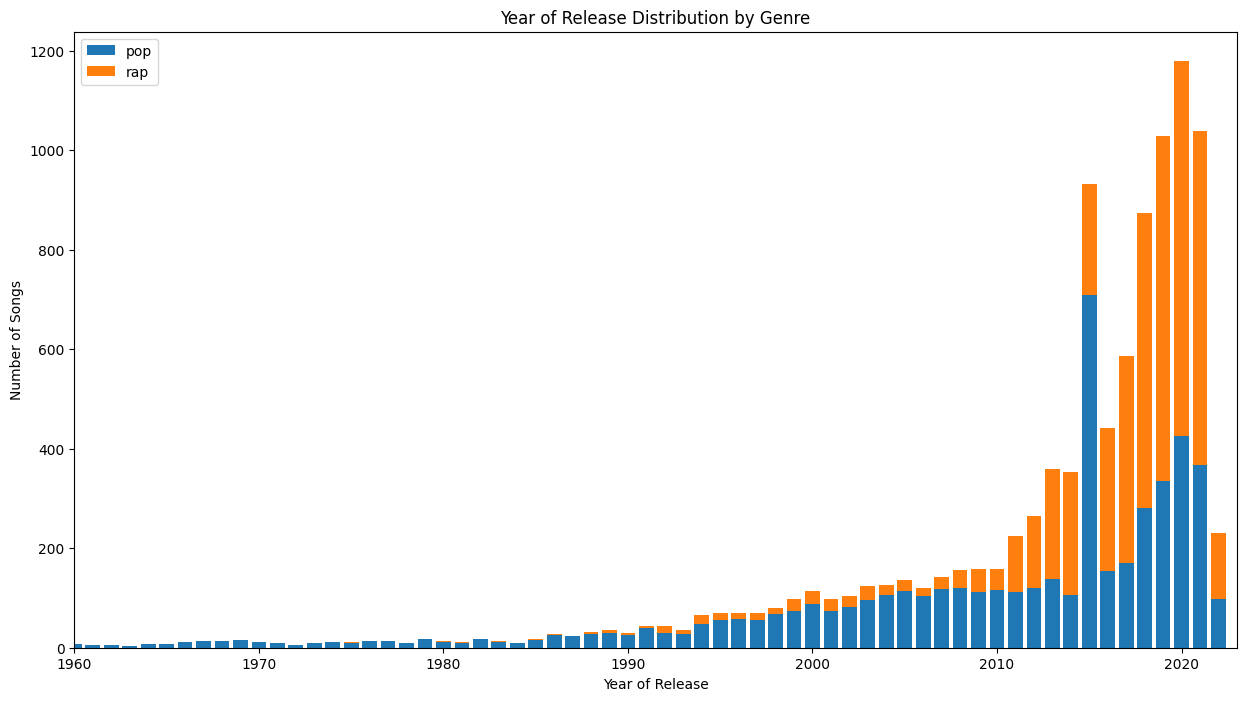

In [ ]:
# Get a map of ((year, genre), 1), then reduce by key to get the counts
year_genre_pairs_counts = cleanedRDD.map(lambda row: ((row["year"], row["tag"]), 1)).reduceByKey(add)
# Switch to a (year, (genre, count)) structure
year_genre_counts_rearranged = year_genre_pairs_counts.map(lambda x: (x[0][0], (x[0][1], x[1])))
# Group by year
grouped_by_year = year_genre_counts_rearranged.groupByKey().mapValues(list).collect()

genre_counts_by_year = {}

# Fill dictionary with genre_counts_by_year
for year, genre_counts in grouped_by_year:
  for genre, count in genre_counts:
    if genre not in genre_counts_by_year:
      genre_counts_by_year[genre] = {}
    genre_counts_by_year[genre][year] = count

# Ensure that each genre has an entry for each year
years = set(range(1960, 2023))
for genre, year_counts in genre_counts_by_year.items():
  for year in years:
    if year not in year_counts:
      genre_counts_by_year[genre][year] = 0

sorted_years = sorted(years)
genre_stacks = {genre: [genre_counts_by_year[genre][year] for year in years] for genre in genre_counts_by_year}

plt.figure(figsize=(15, 8))
bottom_stack = np.zeros(len(years))

for genre, counts in genre_stacks.items():
    plt.bar(sorted_years, counts, bottom = bottom_stack, label = genre)
    bottom_stack += np.array(counts)

plt.xlabel("Year of Release")
plt.ylabel("Number of Songs")
plt.title("Year of Release Distribution by Genre")
plt.xlim(1960, 2023)
plt.legend()
plt.show()

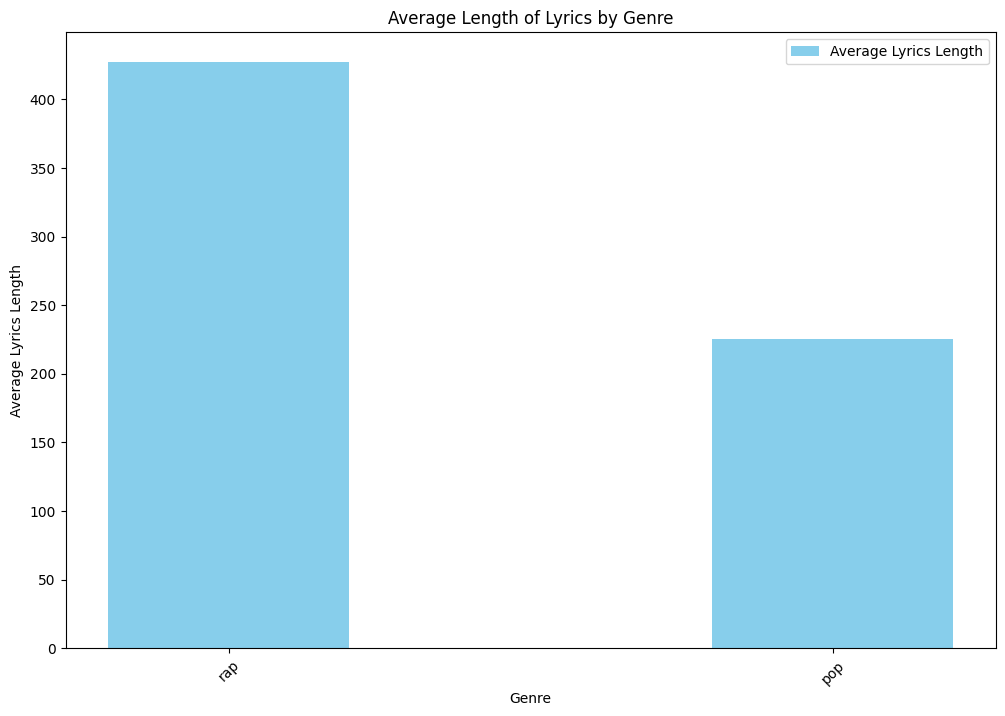

In [ ]:
def lyrics_length(row):
  genre = row["tag"]
  lyrics = row["lyrics"]
  return (genre, (len(lyrics.split()), 1))

length_and_count_by_genre = cleanedRDD.map(lyrics_length).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

average_length_by_genre = length_and_count_by_genre.mapValues(lambda x: x[0] / x[1])
average_length_by_genre_local = average_length_by_genre.collect()
genres, avg_lengths = zip(*average_length_by_genre_local)

n_genres = len(genres)
positions = np.arange(n_genres)
bar_width = 0.4

plt.figure(figsize=(12, 8))
plt.bar(positions, avg_lengths, bar_width, color="skyblue", label="Average Lyrics Length")
plt.xlabel("Genre")
plt.ylabel("Average Lyrics Length")
plt.title("Average Length of Lyrics by Genre")
plt.xticks(positions, genres, rotation=45)
plt.legend()
plt.show()

In [ ]:
def sum_and_count(a, b):
  return (a[0] + b, a[1] + 1)

initial_sum_and_count = (0, 0)

pop_songs_rdd = numericRDD.filter(lambda row: row["tag"] == "pop")
rap_songs_rdd = numericRDD.filter(lambda row: row["tag"] == "rap")

pop_lyrics_sentiment_scores = pop_songs_rdd.map(lambda row: row["lyrics_sentiment_avg"])
rap_lyrics_sentiment_scores = rap_songs_rdd.map(lambda row: row["lyrics_sentiment_avg"])

total_lyrics_sum_pop, count_lyrics_pop = pop_lyrics_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_pop_lyrics_sentiment_score = total_lyrics_sum_pop / count_lyrics_pop if count_lyrics_pop != 0 else 0

total_lyrics_sum_rap, count_lyrics_rap = rap_lyrics_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_rap_lyrics_sentiment_score = total_lyrics_sum_rap / count_lyrics_rap if count_lyrics_rap != 0 else 0

print("Average sentiment score for pop song lyrics: ", average_pop_lyrics_sentiment_score)
print("Average sentiment score for rap song lyrics: ", average_rap_lyrics_sentiment_score)

Average sentiment score for pop song lyrics:  0.1757797408430896
Average sentiment score for rap song lyrics:  -1.3409204104708607


In [ ]:
pop_title_sentiment_scores = pop_songs_rdd.map(lambda row: row["title_sentiment_avg"])
rap_title_sentiment_scores = rap_songs_rdd.map(lambda row: row["title_sentiment_avg"])

total_title_sum_pop, count_title_pop = pop_title_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_pop_title_sentiment_score = total_title_sum_pop / count_title_pop if count_title_pop != 0 else 0

total_title_sum_rap, count_title_rap = rap_title_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_rap_title_sentiment_score = total_title_sum_rap / count_title_rap if count_title_rap != 0 else 0

print("Average sentiment score for pop song titles: ", average_pop_title_sentiment_score)
print("Average sentiment score for rap song titles: ", average_rap_title_sentiment_score)

Average sentiment score for pop song titles:  0.021667903294398064
Average sentiment score for rap song titles:  -0.07820643888700991


In [ ]:
pop_artist_sentiment_scores = pop_songs_rdd.map(lambda row: row["artist_sentiment_avg"])
rap_artist_sentiment_scores = rap_songs_rdd.map(lambda row: row["artist_sentiment_avg"])

total_artist_sum_pop, count_artist_pop = pop_artist_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_pop_artist_sentiment_score = total_artist_sum_pop / count_artist_pop if count_artist_pop != 0 else 0

total_artist_sum_rap, count_artist_rap = rap_artist_sentiment_scores.aggregate(initial_sum_and_count, sum_and_count, lambda a, b: (a[0] + b[0], a[1] + b[1]))
average_rap_artist_sentiment_score = total_artist_sum_rap / count_artist_rap if count_artist_rap != 0 else 0

print("Average sentiment score for pop song artist names: ", average_pop_artist_sentiment_score)
print("Average sentiment score for rap song artist names: ", average_rap_artist_sentiment_score)

Average sentiment score for pop song artist names:  -0.012151440504168196
Average sentiment score for rap song artist names:  -0.01098623539673041


# Machine Learning Setup
* Set up a RDD with the features
* Convert RDD to labelled point
* Split into training and testing data
* Run the data on various ML models in the next section


### All Features
- Title Total Sentiment: the sum of the AFINN score from a song’s title
- Lyrics Total Sentiment:  the sum of the AFINN score from a song’s lyrics
- Artist Total Sentiment:  the sum of the AFINN score from the artist’s name
- Title Average Sentiment: the average of the AFINN score from a song’s title
- Lyrics Average Sentiment: the average of the AFINN score from a song’s lyrics
- Artist Average Sentiment: the average of the AFINN score from the artist’s name
- Year Released: the year in which a song was released
- Number of Views: the number of views on the website Genius.com (the source in which the song’s lyrics came from)



In [ ]:
# Selects all the features we want to use after the label
# use map to get a new rdd with the features in a tuple -- if the numebr of features c
ML_RDD = numericRDD.map(lambda row:
  (
    # -----Label------
    row['label'],

    # ----Features----
    row["title_sentiment"],
    row['lyrics_sentiment'],
    row['artist_sentiment'],

    row['title_sentiment_avg'],
    row['lyrics_sentiment_avg'],
    row['artist_sentiment_avg'],

    row['year'],
    row['views'],
  )
)

# show results
print("Tuple Elements in ML_RDD")
print_rdd_elements(ML_RDD)

Tuple Elements in ML_RDD
(0, 0.0, -10.0, 0.0, 0.0, -0.5986843400892496, 0.0, 2019, 31)
(1, -3.0, -106.0, 0.0, -1.3416407864998738, -5.416346981260518, 0.0, 2020, 722)
(1, 0.0, 16.0, 0.0, 0.0, 2.116950987028628, 0.0, 2014, 3616)
(0, 0.0, 7.0, 0.0, 0.0, 0.4142839674350902, 0.0, 2016, 25)
(1, -2.0, -20.0, -1.0, -1.0, -1.7002089231955175, -0.7071067811865475, 1996, 33)


In [ ]:
# Set up some data points for extra Testing in addition to the testing data to show specific points prediction

# some data points to test against each model --
# -- can empty list if you don't want to see any test points and just go off accuracy score
testDataPoints = create_list_from_rdd(ML_RDD, 5)

# uses the first 5 points

In [ ]:
# Convert to labelled point format to use for machine learning - the label is the lebeled point
from pyspark.mllib.regression import LabeledPoint

# Convert your RDD to a LabeledPoint RDD
labeledPointsRDD = ML_RDD.map(lambda row: LabeledPoint(row[0], row[1:]))

# Show the results
print("Label Point Elements to be used in ML models\n")
print_rdd_elements(labeledPointsRDD)

Label Point Elements to be used in ML models

(0.0,[0.0,-10.0,0.0,0.0,-0.5986843400892496,0.0,2019.0,31.0])
(1.0,[-3.0,-106.0,0.0,-1.3416407864998738,-5.416346981260518,0.0,2020.0,722.0])
(1.0,[0.0,16.0,0.0,0.0,2.116950987028628,0.0,2014.0,3616.0])
(0.0,[0.0,7.0,0.0,0.0,0.4142839674350902,0.0,2016.0,25.0])
(1.0,[-2.0,-20.0,-1.0,-1.0,-1.7002089231955175,-0.7071067811865475,1996.0,33.0])


In [ ]:
# Split the data into training and testing sets
training_data, testing_data = labeledPointsRDD.randomSplit([0.8, 0.2], seed=42)

print("Data split into training and testing datasets/RDDs")
print("\n\nData ready for machine learning models ")

Data split into training and testing datasets/RDDs


Data ready for machine learning models 


# ML Helper Functions
* Get the prediction for a single data
* Test multiple points using get prediction and a model
* Print the accuracy of the model

In [ ]:
# helper function to test of a data point
# Try it Out on a data point
from pyspark.mllib.linalg import Vectors

# take a model and data tupe and get prediction
# display the real and predicted value
def getPrediction(model, dataPoint, realLabel):
  # crate fake data and turn it into a labelled point
  labeled_point = LabeledPoint(dataPoint[0], Vectors.dense(dataPoint[1:]))

  # Use the trained model to make predictions on the new data point
  prediction = model.predict(labeled_point.features)

  # show the results
  return f"Real:{realLabel} | Predicted:{prediction}"


# run through a series of data points - needs to be adjusted if the numebr of features changes
def testOnData(model, modelName):
  dataPoints = testDataPoints # from the Feature Select - uses first couple of points

  print(f"\nTesting Data Points using {modelName}")

  # loop Through list of points
  for index, point in enumerate(dataPoints):
    print(f"- Point {index} | {getPrediction(model, point, point[0])}")


# print the Accuracy and the datafile used to create the models
def printAccuracy(accuracy, modelName):
  print(f"Model created using {data_file_name} containing {num_of_data_rows} rows of data.")
  print(f"{modelName} Model Accuracy", f"{accuracy * 100:.2f}%.")

# Logistic Regression With LBFGS

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils

# Train the Logistic Regression model
model = LogisticRegressionWithLBFGS.train(training_data)
print("Model Trained")

# Make predictions on the testing set
predictions = model.predict(testing_data.map(lambda x: x.features))
print("Predictions Created")

# Evaluate the accuracy
labels_and_predictions = testing_data.map(lambda lp: lp.label).zip(predictions)
accuracy = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())

# output results
printAccuracy(accuracy, "Logistic Regression with LBFGS")
testOnData(model, "Logistic Regression with LBFGS")

Model Trained
Predictions Created
Model created using musicData_10000rows.csv containing 10000 rows of data.
Logistic Regression with LBFGS Model Accuracy 67.11%.

Testing Data Points using Logistic Regression with LBFGS
- Point 0 | Real:0 | Predicted:1
- Point 1 | Real:1 | Predicted:0
- Point 2 | Real:1 | Predicted:1
- Point 3 | Real:0 | Predicted:1
- Point 4 | Real:1 | Predicted:0


# Decision Tree

In [ ]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

# Train the Decision Tree model
dt_model = DecisionTree.trainClassifier(
                                          training_data, # comments on what this is
                                          numClasses=2,
                                          categoricalFeaturesInfo={},
                                          impurity='gini',
                                          maxDepth=5,
                                          maxBins=32
                                        )
print("Model Trained")

# Make predictions on the testing set
dt_predictions = dt_model.predict(testing_data.map(lambda x: x.features))
print("Predictions Created")

# Evaluate the accuracy
dt_labels_and_predictions = testing_data.map(lambda lp: lp.label).zip(dt_predictions)
dt_accuracy = dt_labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())

# output results
printAccuracy(dt_accuracy, "Decision Tree")
testOnData(dt_model, "Decision Tree")

Model Trained
Predictions Created
Model created using musicData_10000rows.csv containing 10000 rows of data.
Decision Tree Model Accuracy 74.07%.

Testing Data Points using Decision Tree
- Point 0 | Real:0 | Predicted:0.0
- Point 1 | Real:1 | Predicted:0.0
- Point 2 | Real:1 | Predicted:0.0
- Point 3 | Real:0 | Predicted:0.0
- Point 4 | Real:1 | Predicted:1.0


# Random Forest Model 1
- First run of random forest as the model alwasys generates results with slight variations

In [ ]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

# Train the Random Forest model
rf_model = RandomForest.trainClassifier(
    training_data,
    numClasses=2,
    categoricalFeaturesInfo={},
    numTrees=10,  # You can adjust the number of trees as needed
    featureSubsetStrategy="auto",
    impurity="gini",
    maxDepth=5,
    maxBins=32,
)
print("Model Trained")

# Make predictions on the testing set
rf_predictions = rf_model.predict(testing_data.map(lambda x: x.features))
print("Predictions Created")

# Evaluate the accuracy
rf_labels_and_predictions = testing_data.map(lambda lp: lp.label).zip(rf_predictions)
rf_accuracy = rf_labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())

# output results
printAccuracy(rf_accuracy, "Random Forest")
testOnData(rf_model, "Random Forest")

Model Trained
Predictions Created
Model created using musicData_10000rows.csv containing 10000 rows of data.
Random Forest Model Accuracy 74.51%.

Testing Data Points using Random Forest
- Point 0 | Real:0 | Predicted:0.0
- Point 1 | Real:1 | Predicted:0.0
- Point 2 | Real:1 | Predicted:1.0
- Point 3 | Real:0 | Predicted:0.0
- Point 4 | Real:1 | Predicted:1.0


# Random Forest Model 2
- Second run of random forest as the model alwasys generates results with slight variations

In [ ]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils

# Train the Random Forest model
rf2_model = RandomForest.trainClassifier(
    training_data,
    numClasses=2,
    categoricalFeaturesInfo={},
    numTrees=10,  # You can adjust the number of trees as needed
    featureSubsetStrategy="auto",
    impurity="gini",
    maxDepth=5,
    maxBins=32,
)
print("Model Trained")

# Make predictions on the testing set
rf2_predictions = rf2_model.predict(testing_data.map(lambda x: x.features))
print("Predictions Created")

# Evaluate the accuracy
rf2_labels_and_predictions = testing_data.map(lambda lp: lp.label).zip(rf2_predictions)
rf2_accuracy = rf2_labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())

# output results
printAccuracy(rf2_accuracy, "Random Forest 2")
testOnData(rf2_model, "Random Forest 2")

Model Trained
Predictions Created
Model created using musicData_10000rows.csv containing 10000 rows of data.
Random Forest 2 Model Accuracy 75.34%.

Testing Data Points using Random Forest 2
- Point 0 | Real:0 | Predicted:0.0
- Point 1 | Real:1 | Predicted:0.0
- Point 2 | Real:1 | Predicted:1.0
- Point 3 | Real:0 | Predicted:0.0
- Point 4 | Real:1 | Predicted:1.0



# Gradient-Boosted Trees (GBT)


In [ ]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils

# Define the GBT model
gbt_model = GradientBoostedTrees.trainClassifier(
    training_data,
    categoricalFeaturesInfo={},
    numIterations=10
)
print("Model Trained")

# Make predictions on the testing set
gbt_predictions = gbt_model.predict(testing_data.map(lambda x: x.features))
print("Predictions Created")

# Evaluate the accuracy
gbt_labels_and_predictions = testing_data.map(lambda lp: lp.label).zip(gbt_predictions)
gbt_accuracy = gbt_labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(testing_data.count())

# output results
printAccuracy(gbt_accuracy, "Gradient Boosted Trees")
testOnData(gbt_model, "Gradient Boosted Trees")

Model Trained
Predictions Created
Model created using musicData_10000rows.csv containing 10000 rows of data.
Gradient Boosted Trees Model Accuracy 74.36%.

Testing Data Points using Gradient Boosted Trees
- Point 0 | Real:0 | Predicted:0.0
- Point 1 | Real:1 | Predicted:0.0
- Point 2 | Real:1 | Predicted:1.0
- Point 3 | Real:0 | Predicted:0.0
- Point 4 | Real:1 | Predicted:1.0


#Model Evaluations and Comparisons

In [ ]:
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# convert to RDDs to be usuable by pyspark.mllib.evaluation
lr_labels_and_predictions = labels_and_predictions.map(lambda x: (x[0], float(x[1])))
dt_labels_and_predictions = dt_labels_and_predictions.map(lambda x: (x[0], float(x[1])))
rf_labels_and_predictions = rf_labels_and_predictions.map(lambda x: (x[0], float(x[1])))
gbt_labels_and_predictions = gbt_labels_and_predictions.map(lambda x: (x[0], float(x[1])))

# get metrics for binary classification
lr_metrics = BinaryClassificationMetrics(lr_labels_and_predictions)
dt_metrics = BinaryClassificationMetrics(dt_labels_and_predictions)
rf_metrics = BinaryClassificationMetrics(rf_labels_and_predictions)
gbt_metrics = BinaryClassificationMetrics(gbt_labels_and_predictions)


/content/spark-3.3.3-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


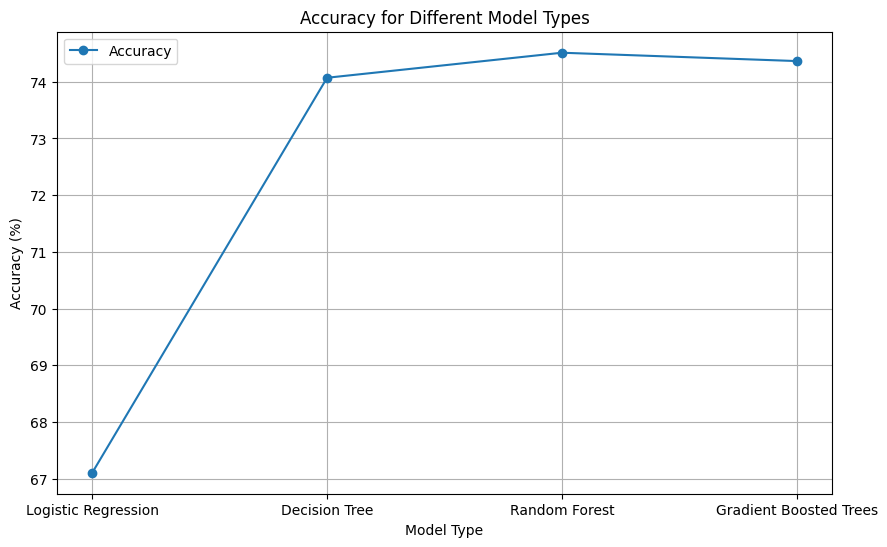

In [ ]:
# -------------------- Accuracy Line Graph for All Models ----------------------------------
model_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']
accuracy_values = [accuracy * 100, dt_accuracy * 100, rf_accuracy * 100, gbt_accuracy *100]
plt.figure(figsize=(10, 6))
plt.plot(model_labels, accuracy_values, marker='o', label='Accuracy')
plt.xlabel('Model Type')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Model Types')
plt.legend()
plt.grid(True)
plt.show()

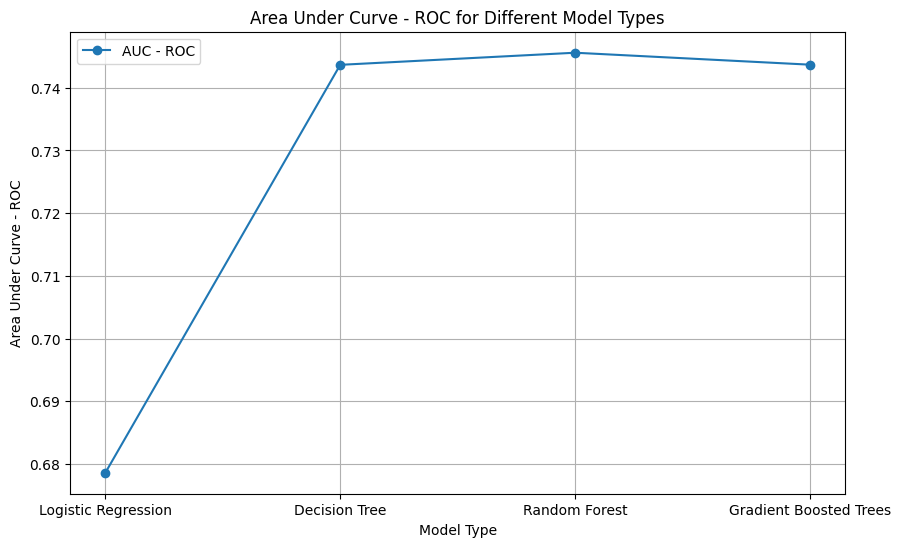

In [ ]:
# -------------------- Area Under Curve ROC Line Graph for All Models ----------------------------------
# get area under curve - ROC for each model
lr_auc = lr_metrics.areaUnderROC
dt_auc = dt_metrics.areaUnderROC
rf_auc = rf_metrics.areaUnderROC
gbt_auc = gbt_metrics.areaUnderROC

# data for AUC-ROC bar plot
auc_values = [lr_auc, dt_auc, rf_auc, gbt_auc]

# plot the area under curve ROC line chart
plt.figure(figsize=(10, 6))
plt.plot(model_labels, auc_values, marker='o', label='AUC - ROC')
plt.xlabel('Model Type')
plt.ylabel('Area Under Curve - ROC')
plt.title('Area Under Curve - ROC for Different Model Types')
plt.legend()
plt.grid(True)
plt.show()

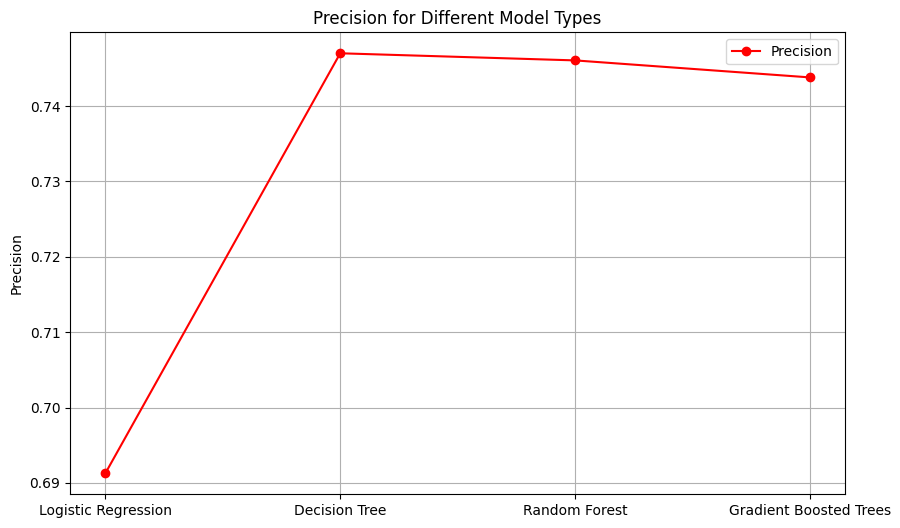

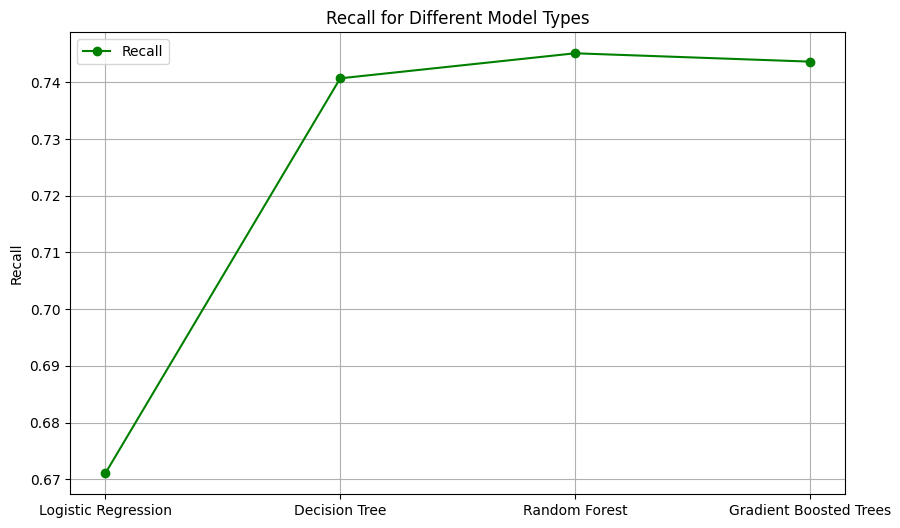

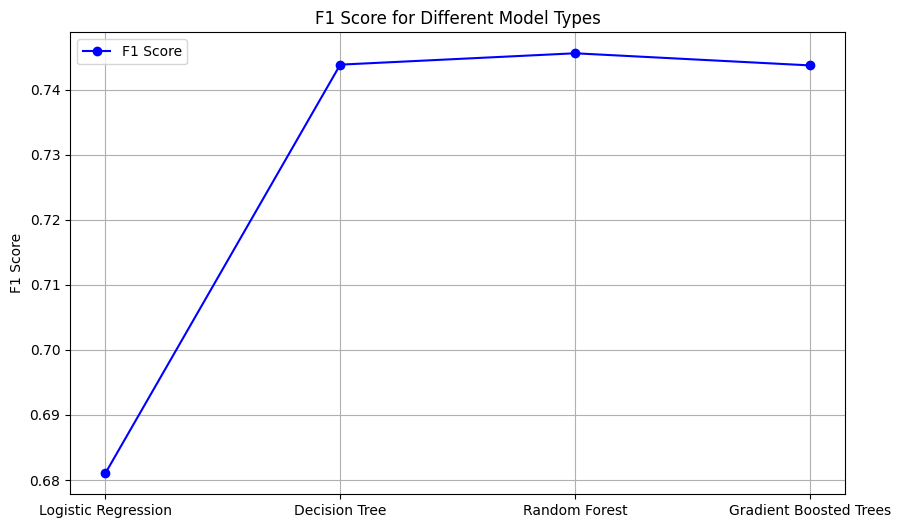

In [ ]:
# -------------------- Precision, Recall, F1 Score Line Graphs for All Models ----------------------------------
from pyspark.mllib.evaluation import MulticlassMetrics

# get metrics for binary classification (using multi-class attributes for relevant metrics)
lr_metrics2 = MulticlassMetrics(lr_labels_and_predictions)
dt_metrics2 = MulticlassMetrics(dt_labels_and_predictions)
rf_metrics2 = MulticlassMetrics(rf_labels_and_predictions)
gbt_metrics2 = MulticlassMetrics(gbt_labels_and_predictions)

# precision for each model
lr_precision = lr_metrics2.weightedPrecision
dt_precision = dt_metrics2.weightedPrecision
rf_precision = rf_metrics2.weightedPrecision
gbt_precision = gbt_metrics2.weightedPrecision

# recall for each model
lr_recall = lr_metrics2.weightedRecall
dt_recall = dt_metrics2.weightedRecall
rf_recall = rf_metrics2.weightedRecall
gbt_recall = gbt_metrics2.weightedRecall

# f1 score for each model
lr_score = (2*lr_recall*lr_precision)/(lr_recall + lr_precision)
dt_score = (2*dt_recall*dt_precision)/(dt_recall + dt_precision)
rf_score = (2*rf_recall*rf_precision)/(rf_recall + rf_precision)
gbt_score = (2*gbt_recall*gbt_precision)/(gbt_recall + gbt_precision)

# data for for each line graph
precision = [lr_precision, dt_precision, rf_precision, gbt_precision]
recall = [lr_recall, dt_recall, rf_recall, gbt_recall]
f1_score = [lr_score, dt_score, rf_score, gbt_score]

# line chart for precision for each model
plt.figure(figsize=(10, 6))
plt.plot(model_labels, precision, marker='o', color='r', label='Precision')
plt.title('Precision for Different Model Types')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# line chart for recall for each model
plt.figure(figsize=(10, 6))
plt.plot(model_labels, recall, marker='o', color='g', label='Recall')
plt.title('Recall for Different Model Types')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# line chart for f1 score for each model
plt.figure(figsize=(10, 6))
plt.plot(model_labels, f1_score, marker='o', color='b', label='F1 Score')
plt.title('F1 Score for Different Model Types')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()
